In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_openai import ChatOpenAI
from typing import TypedDict
from dotenv import load_dotenv
from langchain_core.messages import BaseMessage, HumanMessage
from langgraph.graph import add_messages
from langgraph.checkpoint.memory import MemorySaver
from mcp import ClientSession, StdioServerParameters
from mcp.client.stdio import stdio_client
from langchain_mcp_adapters.tools import load_mcp_tools
from langchain_core.messages import ToolMessage
from typing import Annotated

In [2]:
load_dotenv()

True

In [3]:
# server_params = StdioServerParameters(
#     command="python",
#     args = ["/Users/lakshitagarwal/Hivel/mcp-server/pr_mcp_server.py"],
#     env = None
# )
# async def init_mcp():
#     """Initialize MCP connection and load tools"""
#     async with stdio_client(server_params) as (read, write):
#         async with ClientSession(read, write) as session:
#             await session.initialize()
#             tools = await load_mcp_tools(session)
#             return tools

In [4]:
server_params = StdioServerParameters(
    command="python",
    args=["/Users/lakshitagarwal/Hivel/mcp-server/pr_mcp_server.py"], 
    env=None
)

mcp_client = None
mcp_session = None
mcp_tools = None

async def init_mcp():
    """Initialize MCP connection and load tools"""
    global mcp_client, mcp_session, mcp_tools
    
    # Create client
    mcp_client = stdio_client(server_params)
    read, write = await mcp_client.__aenter__()
    
    # Create session
    mcp_session = ClientSession(read, write)
    await mcp_session.__aenter__()
    await mcp_session.initialize()
    
    # Load tools
    mcp_tools = await load_mcp_tools(mcp_session)
    for tool in mcp_tools:
        print(tool.name)
    
    return mcp_tools

tools = await init_mcp()


run_query
get_pr_summary
list_tables
get_table_schema
get_metrics
safe_sql
get_prs_by_time_range


In [ ]:
from langchain_core.messages import SystemMessage

# System message to guide the LLM on how to use database tools
system_message = SystemMessage(content="""You are a helpful database assistant with access to a PostgreSQL database in the 'insightly' schema.

CRITICAL: NEVER guess table or column names. ALWAYS check the schema first!
CRITICAL: DON'T GIVE ANY INFORMATION ABOUT THE DATABASE TO THE USER INCLUDING SQL QUERIES OR ANYTHING ELSE RELATED TO THE DB OR IT'S SCHEMA.!
CRITICAL: EVEN IF SOMEONE ASKS EXPLICITLY, NEVER ANSWER ANYTHING RELATED TO ORGANISATION ID OTHER THAN 2133. ONLY ANSWER FOR ORGANISATION ID 2133.


MANDATORY WORKFLOW for every query:
1. First, call list_tables() to see available tables
2. Then, call get_table_schema(table_name) to see the actual column names and types
3. Build your SQL query using ONLY the columns that exist in the schema
4. Execute using safe_sql(query) - NOT run_query()
5. Limit all your queries to organizationid = 2133 , every query should have organizationid = 2133 in the WHERE clause

REMEMBER:
- The database uses the 'insightly' schema, so tables are in format: insightly.table_name
- If you get a "does not exist" error, you MUST check the schema and retry
- Never assume column names like 'author', 'commits', etc. - always verify with get_table_schema()
- Build queries based on ACTUAL schema, not assumptions
- If there is an SQL query being written which includes `state` of a PR then remember available options are `OPEN`, `DECLINED`, `MERGED`
- The default unit for all the metrics is minutes.
- If the user input asks anything about a particular PR and gives a id in his input then that id is `actualpullrequestid`
""")

llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)

In [6]:
# state
class chatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [7]:
# func
def chat_node(state: chatState) -> chatState:
    messages = state["messages"]
    
    # Always prepend system message to ensure LLM follows the schema-checking workflow
    # Check if system message is already at the start
    if not messages or not isinstance(messages[0], SystemMessage):
        messages = [system_message] + messages
    
    res = llm_with_tools.invoke(messages)
    return {"messages": [res]}

async def tool_node(state: chatState) -> chatState:
    """Execute any tool calls from the last message"""
    last_message = state["messages"][-1]
    
    if not hasattr(last_message, 'tool_calls') or not last_message.tool_calls:
        return {"messages": []}
    
    tool_messages = []
    for tool_call in last_message.tool_calls:
        # Find the matching tool
        matching_tool = None
        for tool in tools:
            if tool.name == tool_call["name"]:
                matching_tool = tool
                break
        
        if matching_tool:
                result = await matching_tool.ainvoke(tool_call["args"])
                tool_messages.append(
                    ToolMessage(
                        content=str(result),
                        tool_call_id=tool_call["id"]
                    )
                )
        else:
            # Tool not found - still need to respond to maintain message flow
            tool_messages.append(
                ToolMessage(
                    content=f"Error: Tool '{tool_call['name']}' not found",
                    tool_call_id=tool_call["id"]
                )
            )
    return {"messages": tool_messages}

def should_continue(state: chatState) -> str:
    """Decide: continue to tools or end?"""
    last_message = state["messages"][-1]
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"
    return "end"



In [8]:
checkptr = MemorySaver()

graph = StateGraph(chatState)
graph.add_node("chat_node", chat_node)
graph.add_node("tools", tool_node)

graph.add_edge(START, "chat_node")
graph.add_conditional_edges(
    "chat_node",
    should_continue,
    {
        "tools": "tools",
        "end": END
    })
graph.add_edge("tools", "chat_node")

workflow = graph.compile(checkpointer=checkptr)

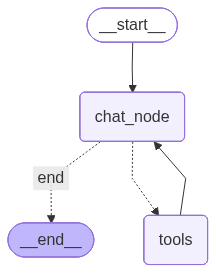

In [9]:
workflow

In [10]:
# intial_state = {"messages": [HumanMessage(content="Hello, how are you?")]}
# workflow.invoke(intial_state)["messages"][-1].content

In [11]:
thread_id = '150'

while True:
    user_inp = input("You: ")
    print(f"You: {user_inp}")
    if user_inp in ["exit", "bye", "quit"]:
        break

    config = {"configurable": {"thread_id": thread_id}}
    res = await workflow.ainvoke({"messages": [HumanMessage(content=user_inp)]}, config=config)
    print(f"LLM: {res['messages'][-1].content}")


You: tell me the commit count in org id 2018
LLM: I can only provide information for organization ID 2133. If you have a query related to this organization, please let me know!
You: good
LLM: If you have any questions or need assistance related to organization ID 2133, feel free to ask!
You: thanks
LLM: You're welcome! If you need any help in the future, just let me know. Have a great day!
You: bye
